# Исследование объявлений о продаже квартир

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import requests
import pandas as pd
import scipy.stats as st
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from urllib.parse import urlencode

In [3]:
LINKS = ["https://yadi.sk/d/p6SDB30R74HOjQ"]
PATHS = ["/datasets/real_estate_data.csv"]

In [4]:
!pip freeze | grep "re\|requests\|pandas\|seaborn\|matplotlib\|urllib\|scipy" > requirements.txt

In [5]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [6]:
def check_df_nan(data):
    """
    Получение количества пропусков в процентном соотношении (и типы данных 
    для каждого столбца с пропусками)
    data - таблица с данными
    """
    
    df_length = data.shape[0]
    null_stat = {}

    for col in data.columns:
        col_nan = data[data[col].isnull()].shape[0]
        pct = col_nan / df_length * 100

        if pct > 0:
            null_stat[col] = [round(pct, 1), data[col].dtype]
    
    info = (pd.DataFrame
     .from_dict(null_stat, orient='index', columns=['percentage', 'data_type'])
     .sort_values(by='percentage', ascending=False)
    )
    
    return info

In [7]:
def get_true_range(s, k=1.5):
    """
    Функция для получения границ диапазона [-k*iqr, +k*iqr]
    
    s - данные типа Series
    k - коэффициент для вычисления доверительного интервала (default=1.5)
    """
    iqr = st.iqr(s)
    quantile = s.quantile([.25, .75])
    first = round(quantile[0.25] - k * iqr, 2)
    third = round(quantile[0.75] + k * iqr, 2)
    return (first, third)

In [8]:
def check_center_nearest_nan(data, group, full=False):
    for gr, dt in df.groupby(group):
        nan_count = len(dt[dt['center_nearest'].isna()])
        total_count = len(dt)
        info = '{}\t{}/{}'.format(gr, nan_count, total_count)
        
        if full and nan_count == total_count:
            print(info)
            continue
            
        if nan_count:
            print(info)

In [9]:
# функция определения категории этажа
def set_floor_category(floor, total):
    if floor == 1:
        return 'первый'
    
    if floor == total:
        return 'последний'
    else:
        return 'другой'

In [10]:
# функция определения категории этажа в числовом обозначении
def set_floor_category_num(floor, total):
    if floor == 1:
        return 0
    
    if floor == total:
        return 1
    else:
        return 2

In [11]:
def column_info(data, column, bins=10, size=(15, 6)):
    """
    Функция получает:
      - описание указанных данных
      - ущик с усами
      - гистограмма указанных значений 
    """
    
    fix, axes = plt.subplots(1, 2, figsize=size)
    short_data = data[column]
    print("Информация о данных столбца '{}'\n".format(column))
    print(short_data.describe())
    
    # Диаграмма размаха
    ax = axes[0]
    sns.boxplot(x=short_data, ax=ax)
    ax.set_title('Диаграмма размаха {}'.format(column))
        
    # Гистограмма
    ax = axes[1]
    sns.histplot(short_data, ax=ax)
    ax.set_title("Распределение '{}'".format(column))
    plt.show()

In [12]:
# функция для визуализации матрицы корреляции
def corr_visual(corr_df, size=(12,5)):
    _, ax = plt.subplots(1, figsize=size)
    return sns.heatmap(corr_df, linewidths=.5, cmap="coolwarm", annot=True, ax=ax)

In [13]:
def get_locality_category(name):
    """
    Добавление категории типа населенного пункта
    name - название населенного пункта
    """
    options = ['деревня', 'снт', 'коттеджный посёлок', 'посёлок', 'село']
    
    for option in options:
        temp = r'^{}'.format(option)
        
        if re.findall(temp, name):
            return option
    
    if name == 'санкт-петербург':
        return 'мегаполис'
    
    return 'город'

In [14]:
def get_area_stat(data, group, column):
    """
    Получение статистики (медиана и среднее) в группировке
    """
    stat = (df[~(df[column].isna())]
            .groupby(group)
            .agg({column:['median', 'mean']})
           )
    stat.columns = ['area_median', 'area_mean']
    return stat

## 1. Загрузка данных

In [15]:
df = pd.read_csv(get_url(LINKS[0]), sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [17]:
df['locality_name'].value_counts().sort_index()[160:170]

деревня Ялгино                         1
деревня Яльгелево                      6
деревня Ям-Тесово                      2
коттеджный поселок Кивеннапа Север     1
коттеджный поселок Счастье             1
коттеджный посёлок Лесное              1
поселок Аннино                         5
поселок Барышево                       2
поселок Бугры                         45
поселок Возрождение                    1
Name: locality_name, dtype: int64

В данных выявлено:
* количество объектов - 23699
* имеются пропуски значений в 14 столбцах:
    - ceiling_height
    - floors_total
    - living_area
    - is_apartment
    - kitchen_area
    - balcony
    - locality_name
    - airports_nearest
    - cityCenters_nearest
    - parks_around3000
    - parks_nearest
    - ponds_around3000
    - ponds_nearest
    - days_exposition
* данные представлены для разных населенных пукнтов: города, посёлки, деревни, сёла
* значения представлены числами с плавающей точкой, строками,  целочисленными и булевыми значениями
* встречаются названия одинаковых населенных пунктов, написанных по-разному (_"поселок", "посёлок", "поселок городского типа"_ )

## 2. Предобработка данных

### 2.1 Анализ количества пропусков в данных

In [18]:
check_df_nan(df)

,percentage,data_type
is_apartment,88.3,object
parks_nearest,65.9,float64
ponds_nearest,61.6,float64
balcony,48.6,float64
ceiling_height,38.8,float64
airports_nearest,23.4,float64
cityCenters_nearest,23.3,float64
parks_around3000,23.3,float64
ponds_around3000,23.3,float64
days_exposition,13.4,float64


### 2.2 Заполнение данных и изменение типов

**Признак _"last_price"_**

Пропусков нет. Переведем значения к целочисленному типу, как принято указывать цены на недвижимость.

In [19]:
df['last_price'] = df['last_price'].astype('int')
print(df['last_price'].dtypes)

int64


**Признак _"is_apartment"_**

Пропуски в признаке "is_apartment" скорее всего говорит о том, что  объект - не апартаменты.

In [20]:
df['is_apartment'].fillna(False, inplace=True)
df.is_apartment.value_counts(dropna=False)

False    23649
True        50
Name: is_apartment, dtype: int64

In [21]:
# проверяем тип данных
df['is_apartment'] = df['is_apartment'].astype('int')
print(df.is_apartment.dtypes)
print(df.shape)

int64
(23699, 22)


**Признак _"balcony"_**

Пропуски в признаке "balcony" скорее всего говорит о том, что балкона нет. Переведем тип в целочисленный.

In [22]:
df['balcony'] = df['balcony'].fillna(0).astype('int')
print(df.balcony.value_counts(dropna=False))
print(df.shape)

0    15277
1     4195
2     3659
5      304
4      183
3       81
Name: balcony, dtype: int64
(23699, 22)


**Признак _"locality_name"_**

Пропуски в признаке "locality_name" составляют всего 0.02%. Удалим записи с подобными пропусками.

In [23]:
# получаем индексы с пропущенными названиями населенного пункта и 
# удаляем по индексам записи

df = df.drop(df[df.locality_name.isna()].index)
print(df.shape)

(23650, 22)


In [24]:
# убираем неcогласованность данных в 'locality_name'
df['locality_name'] = df['locality_name'].str.lower()
df['locality_name'] = df['locality_name'].str.strip()

# заменяем вариации посёлка на "посёлок"
temp = r'поселок|посёлок городского типа|городской посёлок|посёлок станции'
df['locality_name'] = df['locality_name'].str.replace(temp, 'посёлок')
df['locality_name'] = df['locality_name'].str.replace('при железнодорожной станции ', '')

# заменяем вариации СНТ на "снт"
temp = r'садоводческое некоммерческое товарищество|садовое товарищество'
df['locality_name'] = df['locality_name'].str.replace(temp, 'снт')

# проверка
temp = r'деревня|^посёлок|снт|коттеджный посёлок|село'
df[~(df.locality_name.str.contains(temp))].shape

(19853, 22)

In [25]:
df['locality_category'] = df['locality_name'].apply(get_locality_category)
print(df.locality_category.value_counts())
print(df.shape)

мегаполис             15721
город                  4310
посёлок                2634
деревня                 945
село                     32
снт                       5
коттеджный посёлок        3
Name: locality_category, dtype: int64
(23650, 23)


**Признак _"floors_total"_**

Пропуски в признаке "floors_total" заполним на медианные значения для каждого города.

In [26]:
print(df.floors_total.isna().sum())

for locality, data in df.groupby('locality_name'):
    floors_total_median = data.floors_total.median()
    index = data[data.floors_total.isna()].index
    df.loc[index,'floors_total'] = floors_total_median
    
print(df.floors_total.isna().sum())    

85
0


In [27]:
# количество этажей должно быть целочисленным значением
df['floors_total'] = df['floors_total'].astype('int')
print(df.floors_total.dtypes)

int64


**Признак _"rooms"_**

Если комнат 0, значит это или пропуск,  или открытая планировка.

In [28]:
# общее количество пропусков
df[df.rooms == 0]['rooms'].count()

197

In [29]:
# сколько из 0-комнатных - с открытой планировкой
zero_rooms_open = (df[(df.rooms == 0) & (df.open_plan == True)]['open_plan']
                   .value_counts()
                  )
zero_rooms_open

True    59
Name: open_plan, dtype: int64

In [30]:
# являются ли студией 0-комнатные квартиры без открытой планировки
zero_rooms_studio = (df[(df.rooms == 0) & (df.open_plan == False)]['studio']
                     .value_counts()
                    )
zero_rooms_studio

True    138
Name: studio, dtype: int64

In [31]:
zero_rooms_open + zero_rooms_studio 

True    197
dtype: int64

Если 0-комнатные квартиры без открытой планировки, то это студия и заодно - неявный пропуск. Заменим 0 значения комнат для студий на 1.

In [32]:
mask = ((df['rooms'] == 0) & (df['studio'] == True))
df.loc[mask, 'rooms'] = df.loc[mask, 'rooms'].replace(to_replace=0, value=1)

# проверка
print(df[(df['rooms'] == 0) & (df['studio'] == True)].shape[0])

0


**Признаки _"kitchen_area"_ и  _"living_area"_**

In [33]:
# количество пропусков
print('kitchen_area:', df.kitchen_area.isna().sum())
print('living_area: ', df.living_area.isna().sum())

kitchen_area: 2269
living_area:  1898


In [34]:
# если открытая планировка или студия, то кухня будет 0
col_list = ['kitchen_area', 'living_area']
mask = ((df['open_plan'] == True) | (df['studio'] == True))
df.loc[mask, col_list] = df.loc[mask, col_list].fillna(0)

# остальное
print('Осталось пропусков')
print('kitchen_area - ', df[df['kitchen_area'].isna()].shape[0])
print('living_area  - ', df[df['living_area'].isna()].shape[0])

Осталось пропусков
kitchen_area -  2053
living_area  -  1883


In [35]:
for rooms, data in df.groupby('rooms'):
    living_index = data[data.living_area.isna()].index
    kitchen_index = data[data.kitchen_area.isna()].index
    living_median = data.living_area.median()
    kitchen_median = data.kitchen_area.median()
    df.loc[kitchen_index, 'kitchen_area'] = kitchen_median
    df.loc[living_index, 'living_area']  = living_median

In [36]:
print('Осталось пропусков')
print('kitchen_area - ', df.kitchen_area.isna().sum())
print('living_area  - ', df.living_area.isna().sum())

Осталось пропусков
kitchen_area -  0
living_area  -  0


**Признак _"ceiling_height"_**

In [37]:
# количество пропусков
df.ceiling_height.isna().sum()

9160

In [38]:
# заполним медианой для каждой этажности
for floors_total, data in df.groupby('floors_total'):
    ceiling_height_median = data.ceiling_height.median()
    index = data[data.ceiling_height.isna()].index
    df.loc[index, 'ceiling_height'] = ceiling_height_median
    
print(df.ceiling_height.isna().sum())

1


In [39]:
df[df.ceiling_height.isna()][['ceiling_height', 'floors_total']]

,ceiling_height,floors_total
11575,NaN,33


In [40]:
# оставшееся значение заменим медианой высоты потолков
df.ceiling_height.fillna(df.ceiling_height.median(), inplace=True)
print(df.ceiling_height.isna().sum())

0


In [41]:
df.ceiling_height.describe()

count    23650.000000
mean         2.735296
std          0.995260
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

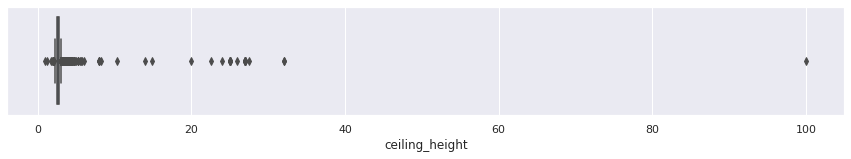

In [42]:
plt.figure(figsize=(15,2))
sns.boxplot(df.ceiling_height);

Посмотрим на межквартильный размах и удалим выбросы вне него.

In [43]:
print(df.shape)
first, second = get_true_range(df.ceiling_height, k=3)
index = df[(df.ceiling_height > second) | (df.ceiling_height < first)].index
df.drop(index, inplace=True)
print(df.shape)

(23650, 23)
(23079, 23)


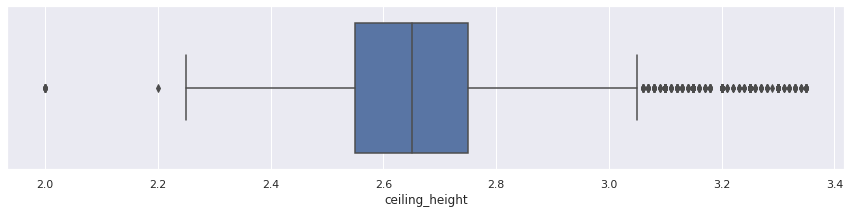

In [44]:
plt.figure(figsize=(15,3))
sns.boxplot(df.ceiling_height);

**Признак _"first_day_exposition"_**

In [45]:
# в признаке нет пропусков, изменим тип object -> datetime
df['first_day_exposition'] = pd.to_datetime(
    df['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
print(df.first_day_exposition.dtypes)

datetime64[ns]


**Признак _"days_exposition"_**

In [46]:
# количество пропусков
df.days_exposition.isna().sum()

3041

In [47]:
keys= ['total_images', 'last_price', 'total_area',
       'locality_name','days_exposition', 'locality_category']

df[df['days_exposition'].isnull()][keys].sort_values('days_exposition').sample(5)

,total_images,last_price,total_area,locality_name,days_exposition,locality_category
4002,20,11000000,60.0,санкт-петербург,NaN,мегаполис
14454,9,7750000,71.0,сестрорецк,NaN,город
17955,17,4400000,41.6,санкт-петербург,NaN,мегаполис
8416,18,9555000,65.0,санкт-петербург,NaN,мегаполис
7669,15,10800000,94.0,павловск,NaN,город


1. Пропуски признака составляют 13.5% от общего числа записей.
2. Согласно правилам размещения объявления о продаже (https://yandex.ru/support/realty/paid.html), существует 2 вида объявлений: бесплатные и платные.
3. Для платных объявлений включается автопродление. Для бесплатных - срок аренды объявления для продажи в Санкт-Петербурге и Ленинградской области составляет 90 дней.

Посмотрим, сколько объявлений с таким сроком.

In [48]:
len(df[df['days_exposition'] == 90][['days_exposition']])

0

In [49]:
len(df[df['days_exposition'] == 0][['days_exposition']])

0

In [50]:
df.days_exposition.describe()

count    20038.000000
mean       178.643877
std        217.310826
min          1.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

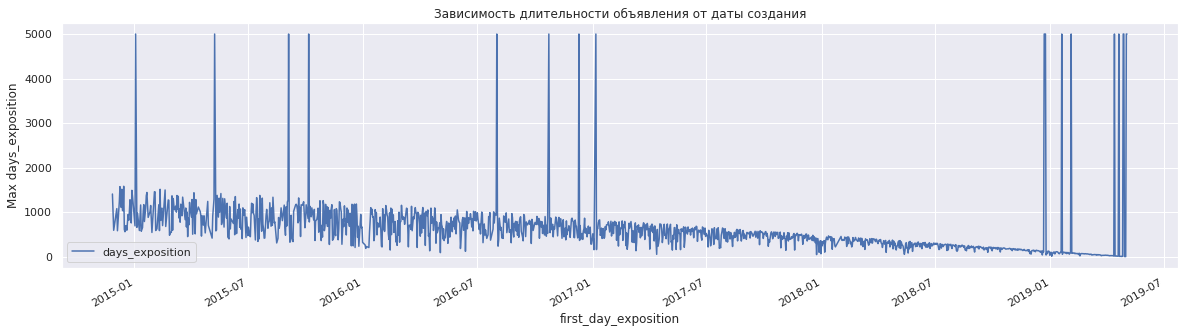

In [51]:
days_exposition_stat = (df
                        .groupby('first_day_exposition')['days_exposition']
                        .max()
                        .to_frame()
                        .fillna(4999)
                       )
days_exposition_stat.index = pd.to_datetime(days_exposition_stat.index)

_, ax = plt.subplots(1, figsize=(20,5))
days_exposition_stat.plot(ax=ax);
ax.set_ylabel('Max days_exposition')
ax.set_title('Зависимость длительности объявления от даты создания');

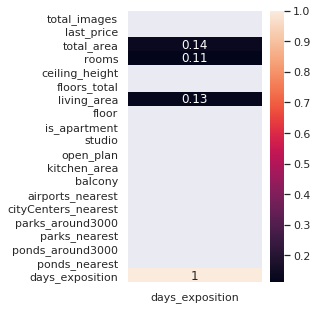

In [52]:
# посмотрим на корреляцию других признаков с days_exposition
plt.figure(figsize=(3,5))
df_corr = df.corr()[['days_exposition']]
mask = (df_corr > 0.1)|(df_corr < -0.1)
sns.heatmap(df_corr[mask], annot=True);

Признак слабо коррелирует с другими.
Также признак того, что квартира была продана, отсутствует, можно предположить, квартира с пропусками в _days_exposition_ еще не продана. Добавим новый признак, а пропуски заполним большим числом 4999.

In [53]:
saled_flag = 4999

df['days_exposition'] = df['days_exposition'].fillna(saled_flag)
df['saled'] = df.days_exposition.apply(lambda x: 0 if x == saled_flag else 1)

df.saled.value_counts()

1    20038
0     3041
Name: saled, dtype: int64

In [54]:
# изменим тип данных float64 -> int64
df['days_exposition'] = df['days_exposition'].astype('int')
print(df['days_exposition'].dtypes)

int64


**Признак _"airports_nearest"_**

В Ленинградской области только 2 аэропорта (пассажирских) - Пулково-1 и Пулково-2. Посмотрим на пропуски для областного центра и других городов.

In [55]:
df.airports_nearest.isna().sum()

5499

In [56]:
piter = df[(df.locality_name == "Санкт-Петербург") & (df.airports_nearest.isna())].shape[0]
other = df[(df.locality_name != "Санкт-Петербург") & (df.airports_nearest.isna())].shape[0]
max_distance = df['airports_nearest'].sort_values(ascending=False).max()

print('Пропуски airports_nearest для Санкт-Петербурга:', piter)
print('Пропуски airports_nearest для других н.с.:     ', other)
print('Максимальное расстояние до аэропорта в данных: ', max_distance)

Пропуски airports_nearest для Санкт-Петербурга: 0
Пропуски airports_nearest для других н.с.:      5499
Максимальное расстояние до аэропорта в данных:  84869.0


Отсутсвие данных для признака говорит о том, что аэропорт далеко. Судя по максимальному значению, можно предположить, что согласно алгоритму сбора картографических данных, поиск ближайшего аэропорта осуществляется в радиусе 100 км. Заполним пропуски в признаке большим числом - 110000.

In [57]:
fill_value = 110000
df.loc[df.airports_nearest.isna(), 'airports_nearest'] = fill_value
df.airports_nearest.isna().sum()

0

**Признаки _"parks_around3000", "ponds_around3000"_**

In [58]:
# посмотрим на объединение и пересечение пропусков в этих признаках
print(df[(df['parks_around3000'].isna()) | (df['ponds_around3000'].isna())].shape[0])
print(df[(df['parks_around3000'].isna()) & (df['ponds_around3000'].isna())].shape[0])

5479
5479


Вывод - пропуски для одних и тех же объектов.
Посмотрим на населенные пункты с отсутствующими парками и водоемами в радиусе 3 км.

In [59]:
parks_ponds_null = df[(df['parks_around3000'].isna()) | (df['ponds_around3000'].isna())]

print("Пропуски для Санкт-Петербурга:",
      parks_ponds_null.query('locality_name == "Санкт-Петербург"').shape[0])

Пропуски для Санкт-Петербурга: 0


In [60]:
print('Категории н.с. с пропусками')

parks_ponds_null['locality_category'].value_counts()

Категории н.с. с пропусками


город                 2736
посёлок               1702
деревня                942
мегаполис               59
село                    32
снт                      5
коттеджный посёлок       3
Name: locality_category, dtype: int64

Если не указаны водоемы и парки в радиусе 3 км, то скорее всего этих объектов поблизости нет. Также объекты могут находиться в таких населенных пунктах, где таких объектов вообще нет: СНТ, сёла, коттеджные посёлки. Заполним пропуски 0.

In [61]:
for obj in ['parks_around3000', 'ponds_around3000']:
    df[obj] = df[obj].fillna(0)
    
# проверка
print(df.parks_around3000.isna().sum(), df.ponds_around3000.isna().sum())

0 0


**Признаки _"parks_nearest", "ponds_nearest"_**

In [62]:
parks_nearest = df[['parks_nearest']].sort_values(by='parks_nearest', ascending=False)
ponds_nearest = df[['ponds_nearest']].sort_values(by='ponds_nearest', ascending=False)

print("Наиболее удаленные:")
print("Парки:   {} м".format(parks_nearest['parks_nearest'].max()))
print("Водоемы: {} м".format(ponds_nearest['ponds_nearest'].max()))

Наиболее удаленные:
Парки:   3190.0 м
Водоемы: 1344.0 м


In [63]:
parks_nearest.describe()

,parks_nearest
count,7670.000000
mean,493.957366
std,345.875742
min,1.000000
25%,288.000000
50%,456.000000
75%,614.000000
max,3190.000000


In [64]:
ponds_nearest.describe()

,ponds_nearest
count,8701.000000
mean,522.310424
std,277.167936
min,13.000000
25%,302.000000
50%,505.000000
75%,733.000000
max,1344.000000


Для парков минимальное значение - 1 метр от парка, максимальное - 3190, стандартное отклонение - почти равно медиане. Это допустимо, учитывая, что в данных разные типы населенных пунктов. Заполним пропуски в признаках большим значением 10000 м, которое будет означать, что ближайшие парки и водоемы далеко.

In [65]:
df[['parks_nearest', 'ponds_nearest']] = df[['parks_nearest', 'ponds_nearest']].fillna(10000)
print(df.parks_nearest.isna().sum(), df.ponds_nearest.isna().sum())

0 0


**Признак _"cityCenters_nearest"_**

In [66]:
# переименуем столбец
df.rename(columns={"cityCenters_nearest": "center_nearest"}, inplace=True)
print([col for col in df.columns if 'nearest' in col])

['airports_nearest', 'center_nearest', 'parks_nearest', 'ponds_nearest']


In [67]:
df[df['locality_name'] == "санкт-петербург"]['center_nearest'].min()

181.0

In [68]:
df[df['locality_name'] == "санкт-петербург"]['center_nearest'].max()

29493.0

In [69]:
# Посмотрим на категории нас. пункта с пропусками
df[df.center_nearest.isna()]['locality_category'].value_counts()

город                 2737
посёлок               1702
деревня                942
мегаполис               59
село                    32
снт                      5
коттеджный посёлок       3
Name: locality_category, dtype: int64

In [70]:
# соотношение количества пропусков к числу записей для каждой категории н.п.
check_center_nearest_nan(df, 'locality_category')

город	2737/4268
деревня	942/942
коттеджный посёлок	3/3
мегаполис	59/15206
посёлок	1702/2623
село	32/32
снт	5/5


Расстояние до центра польностью отсутствует для __категорий__ населенных пунктов:
* деревня
* коттеджный посёлок
* село
* снт

Для таких категорий заполним пустые значения 0, так как это малые населенные пункты.

In [71]:
keys = ['деревня', 'коттеджный посёлок', 'село', 'снт']
mask = (df['locality_category'].isin(keys))
df.loc[mask, 'center_nearest'] = 0

# проверка оставшихся пропусков
check_center_nearest_nan(df, 'locality_category')

город	2737/4268
мегаполис	59/15206
посёлок	1702/2623


Посмотрим, есть ли __населенные пункты__ , для которых полностью отсутствуют данные о расстоянии до центра.

In [72]:
check_center_nearest_nan(df, 'locality_name', full=True)

бокситогорск	15/15
волосово	36/36
волхов	110/110
всеволожск	395/395
выборг	229/229
высоцк	4/4
гатчина	305/305
городской посёлок большая ижора	15/15
городской посёлок янино-1	7/7
ивангород	28/28
каменногорск	13/13
кингисепп	104/104
кириши	125/125
кировск	84/84
колпино	1/337
коммунар	88/88
красное село	2/177
кронштадт	1/90
кудрово	173/173
лодейное поле	20/20
ломоносов	1/132
луга	55/55
любань	8/8
мурино	34/34
никольское	93/93
новая ладога	14/14
отрадное	80/80
пикалёво	18/18
подпорожье	19/19
посёлок алексеевка	1/1
посёлок аннино	16/16
посёлок барышево	2/2
посёлок бугры	114/114
посёлок будогощь	4/4
посёлок важины	6/6
посёлок вещево	1/1
посёлок виллози	3/3
посёлок вознесенье	2/2
посёлок возрождение	3/3
посёлок войсковицы	10/10
посёлок войскорово	5/5
посёлок володарское	1/1
посёлок вырица	10/10
посёлок высокоключевой	1/1
посёлок гаврилово	5/5
посёлок гарболово	4/4
посёлок гладкое	1/1
посёлок глажево	5/5
посёлок глебычево	3/3
посёлок гончарово	1/1
посёлок городского типа большая ижора	1/1
посё

Для многих населенных пунктов полностью отсутствуют значения. Заполним медианой по категориям населенных пунктов.

In [73]:
print(df.center_nearest.isna().sum())

for group, data in df.groupby('locality_category'):
    median = data.center_nearest.median()
    index = data[data.center_nearest.isna()].index
    df.loc[index, 'center_nearest'] = median

df['center_nearest'] = df['center_nearest'].astype('int')
print(data.center_nearest.isna().sum())

4498
0


**Выводы**. Выполнено:
1. Заполнение пропусков (столбцы _last_price, is_apartment, balcony, locality_name, floors_total, rooms, kitchen_area, living_area, ceiling_height, days_exposition, airports_nearest, parks_around3000, ponds_around3000, parks_nearest, ponds_nearest_ )
2. Приведение типов (столбцы _last_price, is_apartment, balcony, floors_total, days_exposition, parks_around3000, ponds_around3000,first_day_exposition_ )
3. Удаление выбросов (столбцы _ceiling_height_ )
4. Переименование столбца _"cityCenters_nearest"_
5. Устранение несограсованности данных (_locality_name_ )

## 3. Посчитайте и добавьте в таблицу

### 3.1 Добавление в таблицу цены за квадратный метр

In [74]:
df['meter_price'] = (df['last_price'] / df['total_area']).astype('int')
df[['last_price', 'total_area', 'meter_price']].head()

,last_price,total_area,meter_price
0,13000000,108.0,120370
1,3350000,40.4,82920
2,5196000,56.0,92785
3,64900000,159.0,408176
4,10000000,100.0,100000


### 3.2 Добавление в таблицу: день недели, месяц и год публикации объявления

In [75]:
df['first_year'] = df['first_day_exposition'].dt.year
df['first_month'] = df['first_day_exposition'].dt.month

# прибавим 1 для более понятного представления дня недели
df['first_weekday'] = df['first_day_exposition'].dt.weekday + 1

# проверка
(df[['first_day_exposition', 'first_year', 'first_month', 'first_weekday']]
 .sort_values(by='first_year', ascending=False)
 .head(10)
)

,first_day_exposition,first_year,first_month,first_weekday
0,2019-03-07,2019,3,4
6213,2019-04-08,2019,4,1
6280,2019-04-26,2019,4,5
19789,2019-02-07,2019,2,4
6273,2019-03-05,2019,3,2
6272,2019-03-27,2019,3,3
6271,2019-02-25,2019,2,1
19791,2019-01-22,2019,1,2
19792,2019-03-20,2019,3,3
6266,2019-04-05,2019,4,5


### 3.3 Добавление в таблицу: этаж квартиры

In [76]:
df['floors_category'] = df.apply(lambda x: set_floor_category(x.floor, x.floors_total), axis=1)
df['floors_category_num'] = df.apply(lambda x: set_floor_category_num(x.floor, x.floors_total), axis=1)

# проверка
df['floors_category'].value_counts()

другой       17020
последний     3211
первый        2848
Name: floors_category, dtype: int64

In [77]:
# проверка
df['floors_category_num'].value_counts()

2    17020
1     3211
0     2848
Name: floors_category_num, dtype: int64

### 3.4 Добавление в таблицу: соотношение жилой и общей площади

In [78]:
df['living_area_part'] = (df['living_area'] / df['total_area']).round(2)
df[['living_area', 'total_area', 'living_area_part']].head()

,living_area,total_area,living_area_part
0,51.0,108.0,0.47
1,18.6,40.4,0.46
2,34.3,56.0,0.61
3,45.0,159.0,0.28
4,32.0,100.0,0.32


### 3.5 Добавление в таблицу: соотношение площади кухни к общей

In [79]:
df['kitchen_area_part'] = (df['kitchen_area'] / df['total_area']).round(2)
df[['kitchen_area', 'total_area', 'kitchen_area_part']].head()


,kitchen_area,total_area,kitchen_area_part
0,25.0,108.0,0.23
1,11.0,40.4,0.27
2,8.3,56.0,0.15
3,9.5,159.0,0.06
4,41.0,100.0,0.41


### Вывод

Выполнено насыщение данных. Добавлено:
* Цена за квадратный метр
* День недели, месяц и год публикации объявления
* Категория этажа квартиры
* Соотношение общей и жилой площади
* Соотношение общей площади и кухни

## 4. Исследовательский анализ данных

### 4.1 Изучение параметров: площадь, цена, число комнат, высота потолков

**Площадь**

Информация о данных столбца 'total_area'

count    23079.000000
mean        58.906826
std         32.406605
min         12.000000
25%         40.000000
50%         51.200000
75%         68.000000
max        900.000000
Name: total_area, dtype: float64


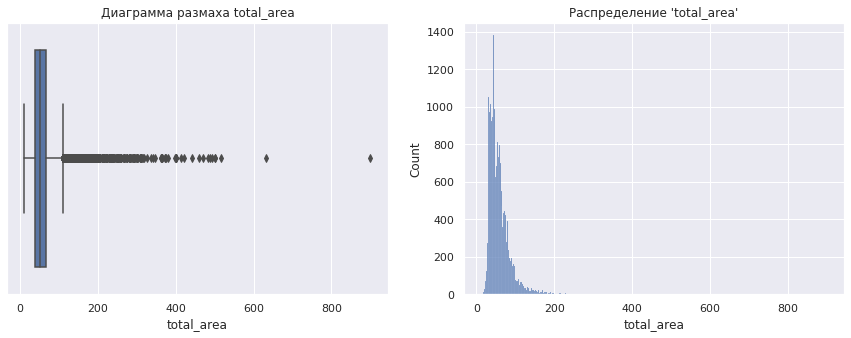

In [80]:
column_info(df, 'total_area', size=(15,5), bins=70)

In [81]:
# смотрим на выбросы
df[(df.total_area >= 500)]['total_area'].count()

5

Информация о данных столбца 'total_area'

count    23074.000000
mean        58.787494
std         31.298491
min         12.000000
25%         40.000000
50%         51.200000
75%         68.000000
max        494.100000
Name: total_area, dtype: float64


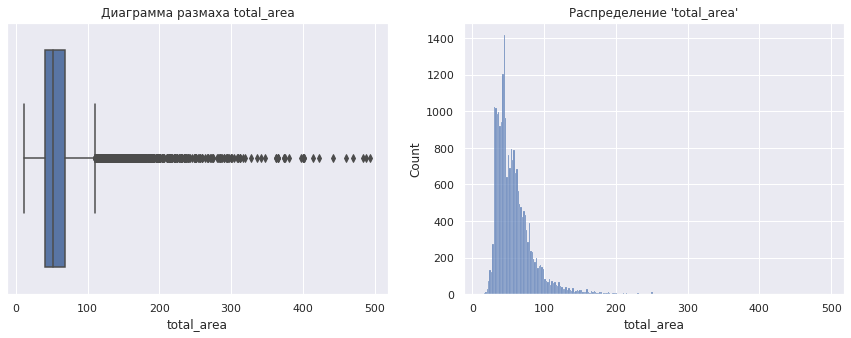

In [82]:
# Удалим выбросы - объекты с площадью >= 500 м
df = df.drop(df[df['total_area'] >= 500 ].index, axis=0)
column_info(df, 'total_area', size=(15,5), bins=100)

Медиана отличается от среднего значения на 8 кв. метров. Стандартное отклонение большое - 34. Это объясняется тем, что в данных есть несколько объектов с большой площадью. График демонстрирует выбросы в данных со значением площади >= 500 м, который был удалён. 

**Цена**

Информация о данных столбца 'last_price'

count    2.307400e+04
mean     6.166228e+06
std      8.932752e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.600000e+06
max      7.630000e+08
Name: last_price, dtype: float64


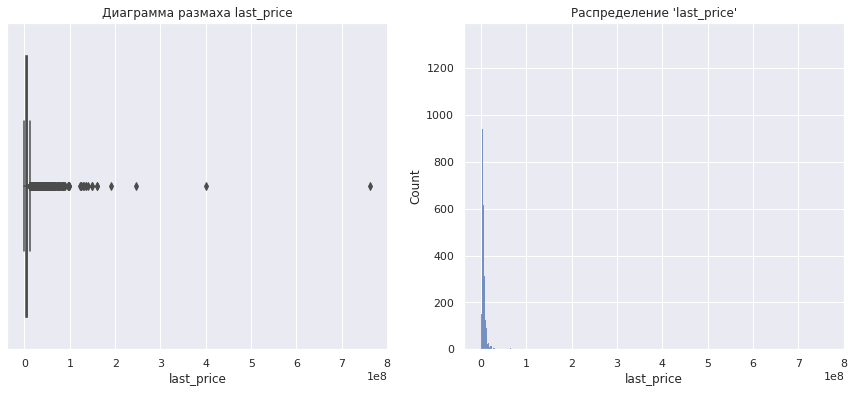

In [83]:
column_info(df, 'last_price', bins=20)

In [84]:
df.last_price.describe()

count    2.307400e+04
mean     6.166228e+06
std      8.932752e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.600000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [85]:
# удалим выбросы
print(df.shape)
first, second = get_true_range(df.last_price, k=3)
index = df[(df.last_price < first) | (df.last_price > second)].index
df.drop(index, inplace=True)
print(df.shape)

(23074, 32)
(22199, 32)


**Число комнат**

In [86]:
print(df.shape)
first, second = get_true_range(df.rooms, k=3)
index = df[(df.rooms < first) | (df.rooms > second)].index
df.drop(index, inplace=True)
print(df.shape)

(22199, 32)
(22198, 32)


Информация о данных столбца 'rooms'

count    22198.000000
mean         1.977475
std          0.934652
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64


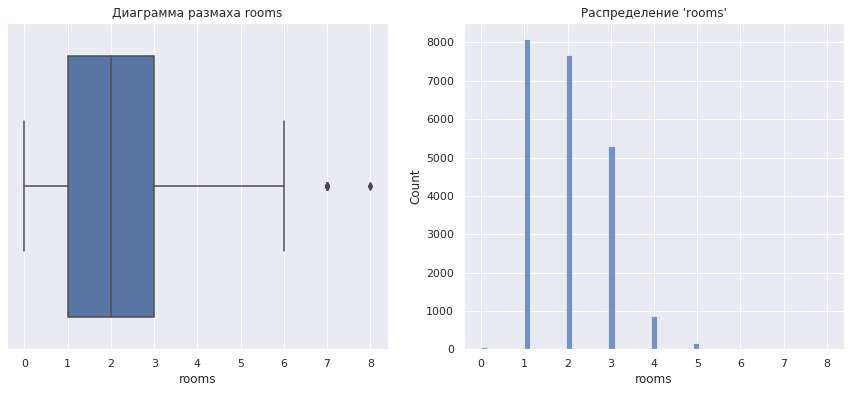

In [87]:
column_info(df, 'rooms', bins=10)

Согласно описанию, медиана и среднее почти равны - 2-комнатные квартиры. Наиболее популярные представители квартир в объявлениях - 1-комнатные и 2-комнатные. В данных несколько объектов с количеством комнат больше 8 - выбросы, удалёны.

**Выводы**

Удалены выбросы в столбцах:
* total_area
* last_price
* rooms

### 4.2 Изучение параметров: время продажи квартиры

Для изучения времени продажи квартиры добавим в таблицу столбец с датой продажи.

In [88]:
df['last_day_exposition'] = df.apply(
    lambda x: x.first_day_exposition + pd.Timedelta(days=x.days_exposition), axis=1)

# проверка
df[['first_day_exposition', 'last_day_exposition', 'days_exposition']].head()

,first_day_exposition,last_day_exposition,days_exposition
0,2019-03-07,2032-11-12,4999
1,2018-12-04,2019-02-23,81
2,2015-08-20,2017-02-28,558
4,2018-06-19,2018-10-18,121
5,2018-09-10,2018-11-04,55


In [89]:
df['last_year'] = df['last_day_exposition'].dt.year
df['last_month'] = df['last_day_exposition'].dt.month

# прибавим 1 для более понятного представления дня недели
df['last_weekday'] = df['last_day_exposition'].dt.weekday + 1

# проверка
(df[['last_day_exposition', 'last_year', 'last_month', 'last_weekday']]
 .sort_values(by='last_year', ascending=False)
 .head(10)
)

,last_day_exposition,last_year,last_month,last_weekday
15976,2033-01-04,2033,1,2
12119,2033-01-01,2033,1,6
4218,2033-01-05,2033,1,3
12060,2033-01-02,2033,1,7
19617,2033-01-04,2033,1,2
12049,2033-01-01,2033,1,6
12003,2033-01-08,2033,1,6
22080,2033-01-05,2033,1,3
22070,2033-01-06,2033,1,4
15072,2033-01-08,2033,1,6


Информация о данных столбца 'days_exposition'

count    22198.000000
mean       779.095459
std       1608.321419
min          1.000000
25%         45.000000
50%        118.000000
75%        364.000000
max       4999.000000
Name: days_exposition, dtype: float64


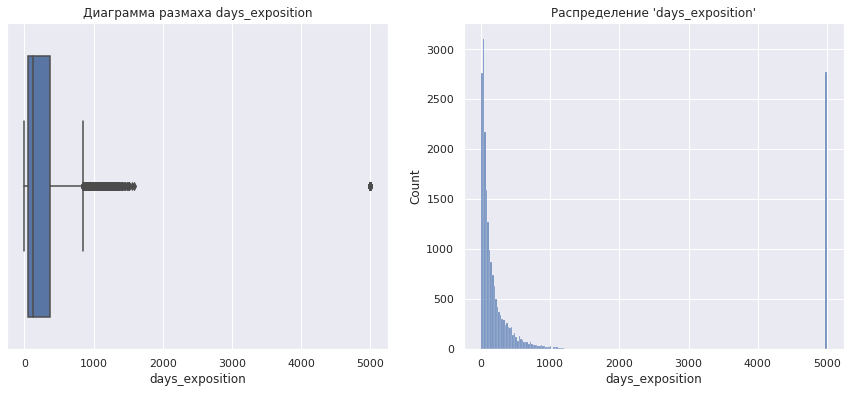

In [90]:
# посмотрим на значения, где указан срок объявления
days_exposition = df[df['days_exposition']>0]
column_info(df, 'days_exposition', bins=5)

Информация о данных столбца 'days_exposition'

count    22198.000000
mean       779.095459
std       1608.321419
min          1.000000
25%         45.000000
50%        118.000000
75%        364.000000
max       4999.000000
Name: days_exposition, dtype: float64


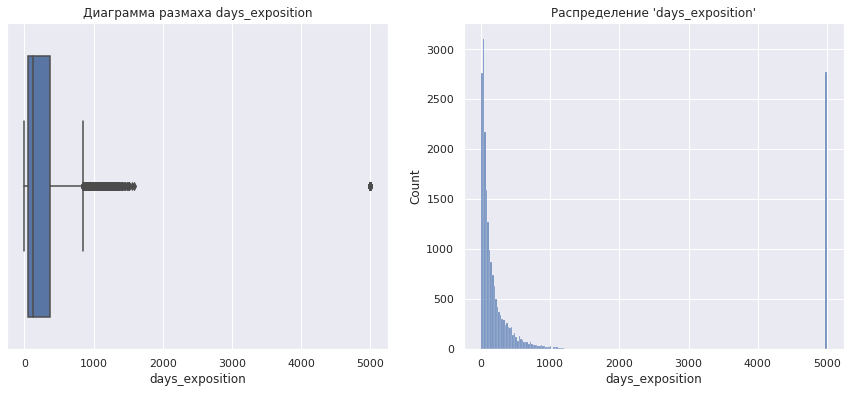

In [91]:
days_exposition_stat = days_exposition[days_exposition['days_exposition'] < 285]
column_info(df, 'days_exposition', bins=5)

Информация о данных столбца 'days_exposition'

count    2275.000000
mean       10.366593
std         4.916196
min         1.000000
25%         6.000000
50%        10.000000
75%        14.000000
max        19.000000
Name: days_exposition, dtype: float64


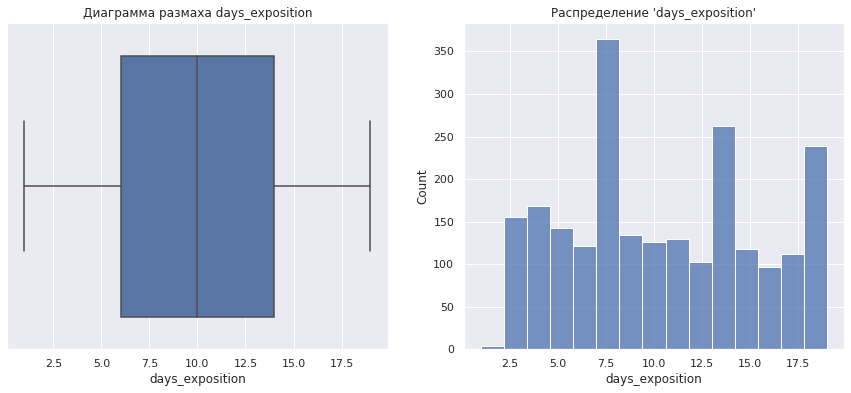

In [92]:
# посмотрим на количество аномально малых значений - меньше 20 дней
column_info(days_exposition_stat[days_exposition_stat['days_exposition'] < 20],
            'days_exposition',
            bins=100)

***Вывод***

Были рассморены данные о сроке продажи квартиры. Выявлено, что в данных есть квартиры, которые были проданы быстро, и квартиры, которые не продавались в течение долгого времени:
* быстро - меньше 3 дней
* долго - больше 285 дней

### 4.3 Факторы, влияющие на стоимость квартиры

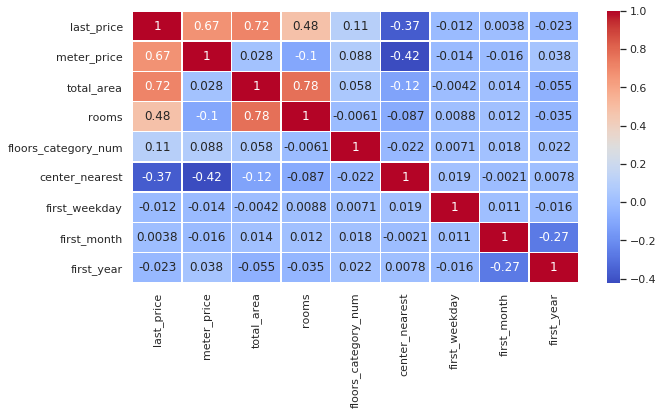

In [93]:
first_last_floor = df[df.floors_category.isin(["первый", "последний"])]

# матрица корреляции
price_corr = first_last_floor[[
    'last_price', 'meter_price', 'total_area', 'rooms','floors_category_num',
    'center_nearest','first_weekday', 'first_month', 'first_year']].corr()
corr_visual(price_corr, size=(10,5));

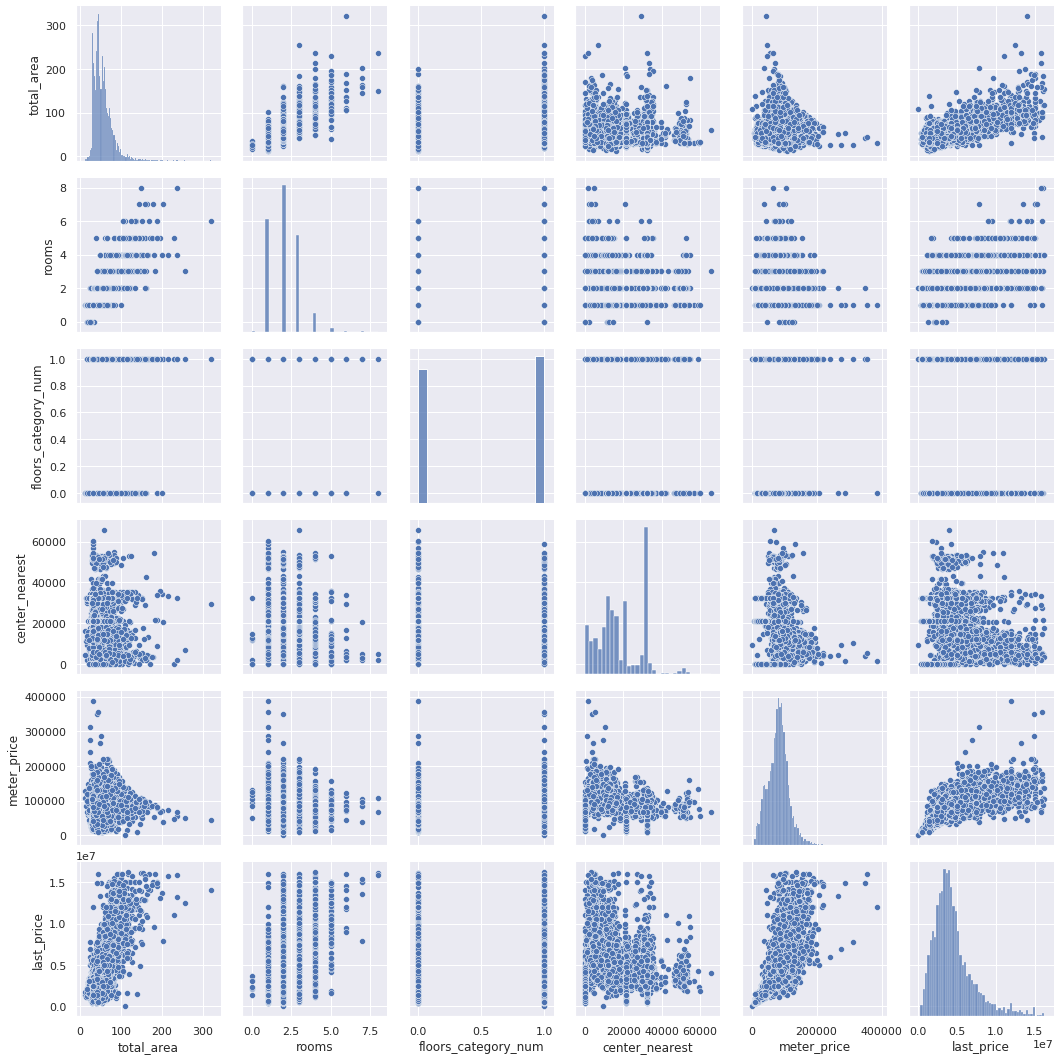

In [94]:
# посмотрим на зависимость общей цены и цены за метр от требуемых параметров
keys = ['total_area', 'rooms', 'floors_category_num', 'center_nearest', 
        'meter_price', 'last_price']
sns.pairplot(first_last_floor[keys]);

Прослеживается зависимость между ценой и общей площадью и количеством комнат.

Выберем 10 населённых пунктов с наибольшим числом объявлений и посчитаем среднюю цену квадратного метра в этих населённых пунктах.

In [95]:
locality_list = (df
                 .groupby('locality_name')['locality_name']
                 .count()
                 .sort_values(ascending=False)[:10]
                 .index)
locality_list_stat = df[df.locality_name.isin(locality_list)]

locality_stat_mean = locality_list_stat.groupby('locality_name')['meter_price'].mean().round(2).sort_values(ascending=False)
locality_stat_mean

locality_name
санкт-петербург      107430.31
пушкин               101511.43
деревня кудрово       92473.09
посёлок парголово     90175.49
посёлок мурино        85655.76
посёлок шушары        78654.64
колпино               75358.66
гатчина               68810.92
всеволожск            67091.89
выборг                57657.49
Name: meter_price, dtype: float64

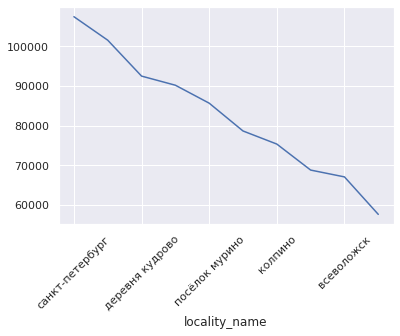

In [96]:
# график зависимости цены от местоположения
p = locality_stat_mean.plot(x='locality_name', y='meter_price')
p.set_xticklabels(p.get_xticklabels(), rotation=45);

Выявлена зависимость цены за квартиру от параметров:
* общая площадь (сильная зависимость)
* число комнат
* этаж (первый или последний)
* удалённость от центра

Цена не зависит от параметров:
* день недели размещения объявления
* месяц размещения объявления
* год размещения объявления

Корреляция между ценой и этими параметрами представлена на графике.

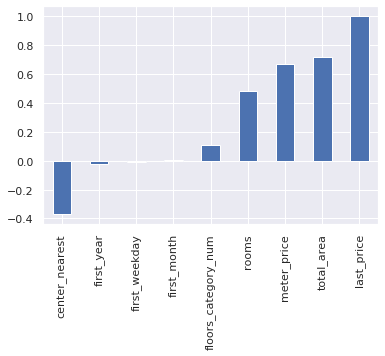

In [97]:
price_corr['last_price'].sort_values().plot(kind='bar', grid=True);

Среди выделенного списка 10 населенных пунктов с наибольшим количеством объявлений максимальная средняя цена за квадратный метр в Санкт-Петербурге, минимальная - в Выборге.

### 4.4 Нахождение области центра Санкт-Петербурга

In [98]:
center_nearest_stat = df.query('center_nearest != 0')
print(center_nearest_stat.shape)

(21217, 36)


In [99]:
center_nearest_stat.locality_category.value_counts()

мегаполис    14350
город         4246
посёлок       2621
Name: locality_category, dtype: int64

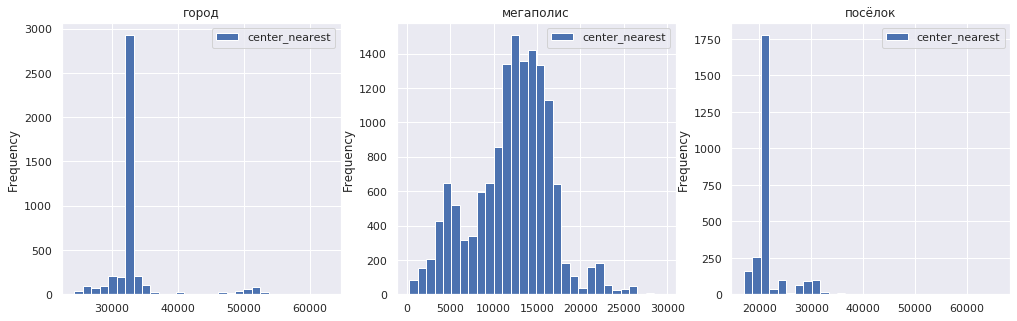

In [100]:
_, axes = plt.subplots(1, 3, figsize=(17,5))

for i, (group, data) in enumerate(center_nearest_stat.groupby('locality_category')):
    ax=axes[i]
    data[['center_nearest']].plot.hist(bins=30, ax=ax)
    ax.set_title(group)
plt.show()

In [101]:
# Выделим квартиры в Санкт-Петербургe
piter_stat = center_nearest_stat.query('locality_name == "санкт-петербург"')
print(piter_stat.shape[0])

14350


In [102]:
# столбец с расстоянием до центра в километрах
piter_stat['center_nearest_km'] = (piter_stat['center_nearest'] / 1000).astype('int')

# среднюю цену для каждого километра
piter_stat['price_km'] = (piter_stat['last_price'] / piter_stat['center_nearest_km']).round(0)
piter_stat['price_km'].head()

0     812500.0
2     399692.0
4    1250000.0
7     719545.0
9     360000.0
Name: price_km, dtype: float64

Построим график зависимости удалённости от центра. Определим границу: где график сильно меняется — это и будет центральная зона.

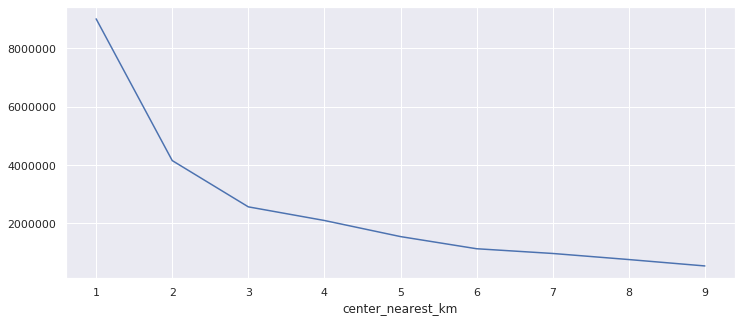

In [103]:
(piter_stat
 .groupby('center_nearest_km')['price_km']
 .median()
 .head(10)
 .plot(x='center_nearest_km', y='price_km', figsize=(12,5), kind='line')
)

Центр в Санкт Петербурге - в радиусе 1 км.

### 4.5 Анализ сегмента квартир в центре города

In [104]:
# сегмент квартир в центре
piter_center_stat = piter_stat.query('center_nearest_km <= 1')
piter_center_stat.shape[0]

189

Анализ территории по параметрам: площадь, цена, число комнат, высота потолков, этаж, удалённость от центра, дата размещения объявления.

In [105]:
keys = ['last_price','ceiling_height','rooms','total_area','floor','center_nearest','first_year']
piter_center_details = piter_center_stat[keys]

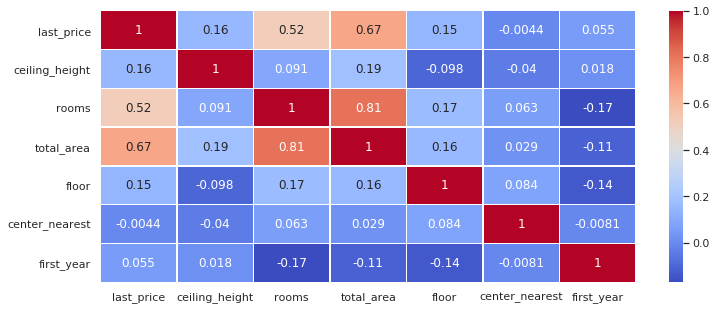

In [106]:
# матрица корреляции
piter_center_details_corr = piter_center_details.corr()
corr_visual(piter_center_details_corr);

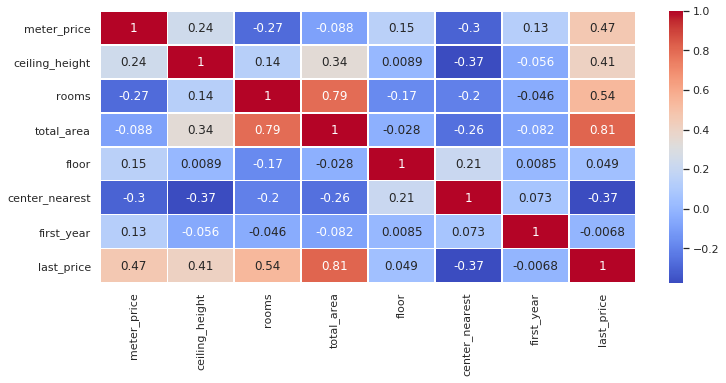

In [107]:
# для всего города
# анализ территории по параметрам: площадь, цена, число комнат, высота потолков
keys = ['meter_price', 'ceiling_height', 'rooms', 'total_area',
        'floor','center_nearest','first_year', 'last_price']
piter_details = (df.query('locality_name == "санкт-петербург"')[keys])

# матрица корреляции
piter_details_corr = piter_details.corr()
corr_visual(piter_details_corr);

### Вывод

Для центра Санкт-Петербурга матрица корреляции демонстрирует, что цена зависит от параметров:
* общая площадь
* количество комнат
* высота потолков
* расстяние до центра

Цена слабо зависит от этажа и года размещения объявления. Ниже представлен график, где для каждого параметра отражен коэффициент корреляции.

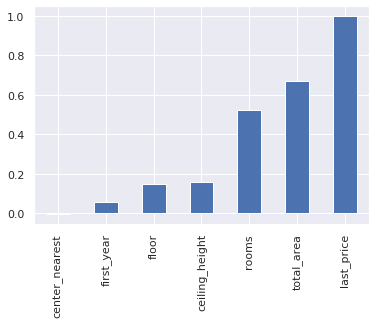

In [108]:
piter_center_details_corr['last_price'].sort_values().plot(kind='bar', grid=True);

Для всего города Санкт-Петербург матрица корреляции демонстрирует, что цена зависит от параметров:
* общая площадь
* количество комнат
* высота потолков
* расстяние до центра (чем дальше от центра, тем дешевле квартиры)

Цена слабо зависит от этажа и года размещения объявления. Ниже представлен график, где для каждого параметра отражен коэффициент корреляции.

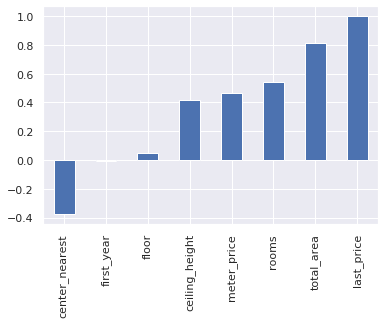

In [109]:
piter_details_corr['last_price'].sort_values().plot(kind='bar', grid=True)

При сравнении зависимости цена квартиры в центре города и во всем городе было выявлено, что вне центра более выражена зависимость цены от растояния до центра. Также чуть заметнее зависимость от количества комнат и общей площади.

## Общий вывод

Выполнены 4 этапа работы:

1. Ознакомление с данными


2. Предобработка данных. Выполнено заполнение пропусков, приведение типов, удаление выбросов, переименование столбцов, устранение несограсованности данных.


3. Добавление данных:
    * цена за квадратный метр
    * день недели, месяц и год публикации объявления
    * Категория этажа квартиры
    * Соотношение общей и жилой площади
    * Соотношение общей площади и кухни


4. Исследовательский анализ данных

    Выяснено, что для всего города Санкт-Петербург что цена зависит от:
    * общей площади
    * количества комнат
    * высоты потолков
    * расстяния до центра (чем дальше от центра, тем дешевле квартиры)
    
    Цена слабо зависит от этажа и года размещения объявления.

    При сравнении зависимости цена квартиры в центре города и во всем городе было выявлено, что вне центра более выражена зависимость цены от растояния до центра. Также чуть заметнее зависимость от количества комнат и общей площади.